# Телекоммуникации

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор.

**Цель проекта:** построить модель ML, позволяющую спрогнозировать разрыв договора клиентом.

**Требования:** метрика $ROC-AUC >= 0.85$.

**Описание данных:**  
*Данные состоят из нескольких файлов*
1. **`contract_new.csv`:**
    - `customerID` — идентификатор абонента;
    - `BeginDate` — дата начала действия договора;
    - `EndDate` — дата окончания действия договора;
    - `Type` — тип оплаты: раз в год-два или ежемесячно;
    - `PaperlessBilling` — электронный расчётный лист;
    - `PaymentMethod` — тип платежа;
    - `MonthlyCharges` — расходы за месяц;
    - `TotalCharges` — общие расходы абонента.
</br></br>
2. **`personal_new.csv`:**
    - `customerID` — идентификатор пользователя;
    - `gender` — пол;
    - `SeniorCitizen` — является ли абонент пенсионером;
    - `Partner` — есть ли у абонента супруг или супруга;
    - `Dependents` — есть ли у абонента дети.
</br></br>
3. **`internet_new.csv`:**
    - `customerID` — идентификатор пользователя;
    - `InternetService` — тип подключения;
    - `OnlineSecurity` — блокировка опасных сайтов;
    - `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
    - `DeviceProtection` — антивирус;
    - `TechSupport` — выделенная линия технической поддержки;
    - `StreamingTV` — стриминговое телевидение;
    - `StreamingMovies` — каталог фильмов.
</br></br>
4. **`phone_new.csv`:**
    - `customerID` — идентификатор пользователя;
    - `MultipleLines` — подключение телефона к нескольким линиям одновременно.

Информация о договорах актуальна на **1 февраля 2020 года**

**Основные этапы работ:**
1. Загрузка, объединение и предобработка данных.
2. Исследовательский анализ.
3. Обучение нескольких моделей ML.
4. Выбор лучшей модели и оценка ее качества на тестовых данных.

## Библиотеки и функции

In [1]:
!pip install -U -q matplotlib seaborn pandas numpy==1.24.3 scipy scikit-learn catboost optuna phik shap

In [2]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import optuna
import shap

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    precision_recall_curve)

from catboost import CatBoostClassifier

optuna.logging.set_verbosity(optuna.logging.WARNING)
sns.set_style('whitegrid')

In [3]:
class Ansi:
    green = '\033[32m'
    red = '\033[31m'
    bold = '\033[1m'
    underline = '\033[4m'
    end = '\033[0m'

In [4]:
def to_snake_case(name):
    return re.sub(r'(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])', '_', name).lower()

In [5]:
def chart_pie(data, col, ax, hue=None):
    """
    Displaying a pie chart with the possibility of additional grouping by target
    """
    
    group = data[col].value_counts()
    
    if hue is not None:
        # при включенной группировке сортируем значения по убыванию, так же
        # как возвращает метод .value_counts()
        group_index = group.index
        group_hue = data.groupby([col, hue])[col].agg('count').loc[group_index]

        # дополнительная таблица с процентной долей для target=1 внутри каждой категории
        group_hue_percent = group_hue / group
        group_hue_percent = group_hue_percent.apply(lambda x: f'{x:.0%}')
        group_hue_percent.loc[:, 0] = ''


    ax.pie(
        x=group,
        labels=group.index,
        labeldistance=1.13,
        radius=1,
        autopct='%.1f%%', 
        startangle = 90,
        pctdistance=.57,
        wedgeprops={'width': .2}, 
        colors=sns.color_palette('pastel')
    )


    if hue is not None:
        palette = sns.color_palette('tab20')
        # переставляем порядок оттенков: сначала тусклый, затем яркий
        reordered_palette = [palette[i + 1] if i % 2 == 0 else palette[i - 1] for i in range(len(palette))]
        
        ax.pie(
            x=group_hue,
            labels = group_hue_percent,
            labeldistance=1.06,
            radius=1.07,
            startangle = 90,
            textprops={'size': 8, 'weight': 'bold', 'color': 'gray'},
            wedgeprops={'width': .06}, 
            colors=reordered_palette
        )

    ax.set_title(col, fontdict={'fontsize': 10, 'fontweight': 'bold'}, y=0.97)

In [6]:
def hist_box_chart(data, col, hue=None, bins=100):
    """
    Displaying a pair of histplot and boxplot
    """
    
    fig, ax = plt.subplots(2, figsize=(14, 5), sharex=True, gridspec_kw={"height_ratios": (1, .25)})
    plt.subplots_adjust(hspace=.05)
    
    # histplot
    ax[0].set_title(col, fontdict={'fontsize': 10, 'fontweight': 'bold'})
    sns.histplot(data=data, x=col, hue=hue, ax=ax[0], kde=True, bins=bins, edgecolor='black', stat='density', common_norm=False)
    ax[0].axvline(x=data[col].median(), color='black', alpha=.5, label=f'median ({data[col].median():.2f})')
    ax[0].axvline(x=data[col].mean(), color='black', alpha=.5, label=f'mean ({data[col].mean():.2f})', linestyle='dashed')
    ax[0].legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    
    # boxplot
    sns.boxplot(data=data, x=col, hue=hue, ax=ax[1], boxprops={'alpha': .5, 'edgecolor': 'black'}, linewidth=.8)
    ax[1].legend(loc='upper left', bbox_to_anchor=(1.01 , 1))
    ax[1].set_xlabel('')

    plt.show()

In [7]:
def corr_matrix(matrix, size=9, title='correlation $\phi_K$'):
    """Вывод матрицы корреляции"""
    fig, ax = plt.subplots(figsize=(size, size))
    sns.heatmap(matrix, annot=True, fmt='.2f', cmap='Blues', square=True, cbar=False, ax=ax)
    ax.set_title(title, fontsize=14, fontweight='bold')
    plt.show()


def cheddock_scale(coef):
    """Интерпретация коэффициентов корреляции по шкале Чеддока"""
    try:
        if coef < 0.1:
            return 'no correlation'
        elif 0.1 <= coef < 0.3:
            return 'weak'
        elif 0.3 <= coef < 0.5:
            return 'moderate'
        elif 0.5 <= coef < 0.7:
            return 'perceptible'
        elif 0.7 <= coef < 0.9:
            return 'high'
        else:
            return 'multicollinearity'
    except:
        pass


def corr_sort(matrix):
    """Вывод отсортированной таблицы коэффициентов корреляции"""
    corr = (
        matrix
        .abs()
        .stack()
        .reset_index()
        .rename(columns={0: "corr", 'level_0': 'feature_1', 'level_1': 'feature_2'})
        .query('feature_1 != feature_2')
        .sort_values(by='corr', ascending=False)
        .loc[::2]
        .reset_index(drop=True)
    )
    corr['cheddock_scale'] = corr['corr'].apply(cheddock_scale)
    return corr


def target_corr(matrix, col):
    """Вывод коэффициентов целевого признака"""
    target_corr = pd.DataFrame(matrix[col].abs().drop(col).sort_values(ascending=False))
    target_corr.columns = ['corr']
    target_corr['cheddock_scale'] = target_corr['corr'].apply(cheddock_scale)
    return target_corr

In [ ]:
# constants
SEED = 50824

PATH = '/datasets'

## Загрузка данных и первичный осмотр

In [9]:
contract = pd.read_csv(os.path.join(PATH, 'contract_new.csv'), parse_dates=['BeginDate'])
personal = pd.read_csv(os.path.join(PATH, 'personal_new.csv'))
internet = pd.read_csv(os.path.join(PATH, 'internet_new.csv'))
phone = pd.read_csv(os.path.join(PATH, 'phone_new.csv'))

data = [contract, personal, internet, phone]
data_name = ['contract', 'personal', 'internet', 'phone']

Большинство названий столбцов в датафреймах представлено в стиле **PascalCase**, но так же есть несколько в **сamelCase**, такие как (`customerID`, `gender`).  
Раз уж мы возьмемся за переименование названий колонок, то приведем их все к **snake_case** - к стилю, в котором принято в Python называть переменные.

In [10]:
for df in data:
    df.rename(columns=lambda x: to_snake_case(x), inplace=True)

Рассмотрим первые несколько строк каждого датафрейма, а так же общую информацию о нем.

In [11]:
for df, df_name in zip(data, data_name):
    print(f'{Ansi.bold}{Ansi.green}{df_name}:{Ansi.end}')
    display(df.head(3))
    df.info(memory_usage=False)
    print('\n\n')

contract:


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)


personal:


,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)


internet:


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)


phone:


,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)




Таблицы `contract` и `personal` содержат по **7043** записи. В первом датафрейме колонка `total_charges` имеет строковый тип данных, хотя должен быть числовой; необходимо проверить и исправить неверные значения.

В таблицах `internet` и `phone` записей меньше, так как есть абоненты, пользующиеся интернет-услугами, но не использующие телефонию, и наоборот.  
Тип данных во всех колонках, кроме одной, корректный.  
</br>

Поправим тип данных в столбце `total_charges`. Для начала отсортируем уникальные значения и отобразим несколько из начала списка.

In [12]:
sorted(contract['total_charges'].unique())[:3]

[' ', '100.17', '100.19']

Данный признак содержит пропуски значений в виде одного пробела. Посчитаем количество таких значений.

In [13]:
display(contract[contract['total_charges'] == ' '])
contract[contract['total_charges'] == ' '].shape[0]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


11

Имеется 11 таких пропусков. Во всех строках дата начала договора совпадает с текущей датой, поэтому, наиболее вероятно, что пользователи еще не успели внести оплату.  
Для корректного заполнения пропусков узнаем, с какие округлением представлена дата начала договора. Возьмем 10 случайных уникальных дат.

In [14]:
begin_date_unique = contract['begin_date'].unique().tolist()
np.random.choice(begin_date_unique, 10, replace=False).tolist()

[Timestamp('2016-07-01 00:00:00'),
 Timestamp('2015-02-01 00:00:00'),
 Timestamp('2019-03-01 00:00:00'),
 Timestamp('2015-05-01 00:00:00'),
 Timestamp('2015-09-01 00:00:00'),
 Timestamp('2019-08-01 00:00:00'),
 Timestamp('2018-06-01 00:00:00'),
 Timestamp('2018-05-01 00:00:00'),
 Timestamp('2014-07-01 00:00:00'),
 Timestamp('2016-01-01 00:00:00')]

Видим, что даты округлены до первого числа каждого месяца. Напрашивается вариант заполнить пропуски в столбце `total_charges` данными из `monthly_charges` для новых пользователей. Возьмем предыдущий месяц и посмотрим, отличаются ли значения в этих двух столбцах для абонентов, заключивших договор чуть ранее.

In [15]:
contract_2020_01_01 = contract.loc[contract['begin_date'] == '2020-01-01', ['monthly_charges', 'total_charges']].astype(float)
contract_2020_01_01 = contract_2020_01_01['monthly_charges'] - contract_2020_01_01['total_charges']

print(f'mean: {contract_2020_01_01.mean():.2f}')
print(f'median: {contract_2020_01_01.median():.2f}')
print(f'std: {contract_2020_01_01.std():.2f}')

mean: -0.98
median: 0.00
std: 1.54


Для абонентов, заключивших договор в предыдущем месяце, сумма `total_charges` в среднем на единицу больше, чем в `monthly_charges`, а медианная разница вообще равна 0, что говорит о том, что как минимум в половине случаев значения полностью совпадают. Следовательно, в нашем случае будет корректным заполнить пропуски в общих тратах значениями месячного платежа.

In [16]:
# заменяем пробелы на специальные значения NaN и устанавливаем тип столбца на float
contract['total_charges'] = contract['total_charges'].replace(' ', np.nan).astype(float)
# заполняем пропуски
contract['total_charges'] = contract['total_charges'].fillna(contract['monthly_charges'])

contract.sort_values(by='begin_date', ascending=False).head(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,73.35
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,25.75
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,52.55
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,25.35
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,19.85


Пропуски в виде пробела успешно устранены.

Теперь посмотрим наличие пропусков во всех датафреймах, а так же проверим наличие явных дубликатов.

In [17]:
for df, df_name in zip(data, data_name):
    missing_values = df.isna().sum()[df.isna().sum() > 0]
    duplicates = df.duplicated().sum()
    print(f'{Ansi.bold}{Ansi.green}{df_name}:{Ansi.end}')
    print(f'count duplicates: {Ansi.bold}{duplicates}{Ansi.end}' if duplicates else 'no duplicates')
    print(f'{Ansi.underline}missing values:{Ansi.end} \n {missing_values}' if len(missing_values) > 0 else 'no missing values', '\n')

contract:
no duplicates
no missing values 

personal:
no duplicates
no missing values 

internet:
no duplicates
no missing values 

phone:
no duplicates
no missing values 



Явных дубликатов а так же пропусков не обнаружено.
Отдельно убедимся, что признак с уникальным идентификатором пользователя не содержит дублей.

In [18]:
for df, df_name in zip(data, data_name):
    duplicates = df['customer_id'].duplicated().sum()
    print(f'{Ansi.bold}{Ansi.green}{df_name}:{Ansi.end}')
    print(f'count duplicates customer_id: {Ansi.bold}{duplicates}{Ansi.end}' if duplicates else 'no duplicates customer_id', '\n')

contract:
no duplicates customer_id 

personal:
no duplicates customer_id 

internet:
no duplicates customer_id 

phone:
no duplicates customer_id 



Столбец `customer_id` в каждой из таблиц содержит только уникальные значения.  
Проверим наличие неявных дубликатов, для этого отобразим уникальные значения для каждого категориального признака.

In [19]:
for df in data:
    for col in df.select_dtypes(include='object').columns.tolist():
        if col not in ['customer_id']:
            print(f'{col}:', sorted(df[col].dropna().unique()), '\n')

end_date: ['2014-06-01', '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01', 'No'] 

type: ['Month-to-month', 'One year', 'Two year'] 

paperl

Неявных дубликатов в предоставленных данных так же не обнаружено.  

Отметим, что признак `end_date` имеет значение `No` для действующих клиентов, и дату расторжения договора (с округлением до месяца) для бывших пользователей.

## Объединение данных

Для дальнейшей работы нам необходимо объединить все 4 отдельных датафрейма в один. Слияние будем производить по столбцу `customer_id`. Что бы за одно действие произвести слияние сразу всех таблиц, необходимо в качестве индекса установить общий столбец.

In [20]:
for df in data:
    df.set_index('customer_id', inplace=True)

print('total count of features:', sum([len(df.columns) for df in data]))

total count of features: 19


In [21]:
data = contract.join([personal, internet, phone], how='outer')

display(data.head(3))
print('\nshape:', data.shape)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No



shape: (7043, 19)


Слияние произведено методом `outer`, т.е. в итоговый датафрейм попали все id пользователей, встретившиеся хотя бы в одном датафрейме. Получившееся количество строк, а именно **7043**, равно количеству строк в двух самых больших исходных таблицах, что говорит о том, что в отдельных таблицах не было таких id, которые бы не встретились в других. Для нас это означает, что информация по каждому абоненту будет максимально полной.  
Количество признаков признаков в объединенной таблице равно сумме всех признаков в исходных таблицах - **19**.  
Из вышесказанного можно заключить, что таблицы объединены успешно.

Так как некоторые клиенты используют только интернет-услуги или только телефонию, то получившиеся пропуски в колонках, полученных из таблиц `internet`, `phone`, заполним значением `no service`.

In [22]:
print(f'{Ansi.bold}before:')
data.isna().sum()

before:


begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

In [23]:
column_list = list(internet.columns) + list(phone.columns)
data[column_list] = data[column_list].fillna('no service')

print(f'{Ansi.bold}after:')
data.isna().sum()

after:


begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

Появившиеся пропуски заполнены.

## Предобработка данных

In [24]:
print(data.info())

data.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   object        
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   int64         
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   7043 non-null   object        
 12  online_security    7043 non-null   object        
 13  online_backup      7043 non-null   object        
 14

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no service
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No


В столбце `senior_citizen` содержится бинарный признак, имеющий числовые значения `0` и `1`. Для того, что бы при дальнейшей работе мы не перепутали его с количественным признаком, приведем его значения к строковому типу данных.

In [25]:
print(f'{Ansi.bold}before:{Ansi.end}')
print(data['senior_citizen'].dtype, '\n')

data['senior_citizen'] = data['senior_citizen'].astype(str)
print(f'{Ansi.bold}after:{Ansi.end}')
print(data['senior_citizen'].dtype)

before:
int64 

after:
object


Добавим в таблицу целевой признак, отражающий статус клиента(бывший и действующий). Сформируем его на основе столбца `end_date` - если в исходном столбце значением является дата - то таргет будет равен `1`, в противном случае - `0`.

In [26]:
data['is_former'] = data['end_date'].apply(lambda x: int(x != 'No'))

В качестве дополнительного признака добавим количество дней, прошедших со дня заключения договора. Если договор расторгнут, то конечной датой будет дата расторжения.  Важно помнить, что информация о договорах актуальна на **1 февраля 2020 года**.

In [27]:
def timedelta(row):
    begin = row['begin_date']
    if row['end_date'] != 'No':
        end = pd.Timestamp(row['end_date'])
    else:
        end = pd.Timestamp('2020-02-01')

    return (end - begin).days
    
data['days_since_contract'] = data.apply(timedelta, axis=1)

Так же сформируем категориальный признак, показывающий, сколько интернет-услуг подключено у абонента. Для этого просто посчитаем сколько раз встретилось `Yes` в признаках, связанных с интернет-сервисом. Всего таких категорий **6**, но полагаю, что будет достаточно выделить тех, кто пользуется базовым тарифом, абонентов с 1-2 услугами, и так же тех, у кого много подключенных услуг - 3 и более.

In [28]:
def counting_services(row):
    if row['internet_service'] == 'no service':
        return 'no service'
        
    count_services = 0
    for col in ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']:
        if row[col] == 'Yes':
            count_services += 1

    if count_services == 0:
        return '0'
    elif count_services < 3:
        return '1-2'
    else:
        return 'more than 2'


data['count_net_services'] = data.apply(counting_services, axis=1)

Для дальнейшей работы признаки `begin_date` и `end_date` больше не понадобятся, так как новые сгенерированные признаки содержат в себе данную информацию.

In [29]:
data = data.drop(['begin_date', 'end_date'], axis=1)

Взглянем на наш датасет после небольших преобразований

In [30]:
data.head(5)

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,is_former,days_since_contract,count_net_services
customer_id,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no service,0,31,1-2
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036,1-2
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123,1-2
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no service,0,1371,more than 2
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153,0


Лишние признаки удалены, новые - успешно сформированы. Пора переходить к анализу.

## Исследовательский анализ

Для начала посмотрим, какое распределение имеет таргет

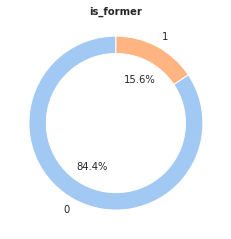

In [31]:
_, ax = plt.subplots(figsize=(4, 4))
chart_pie(data, 'is_former', ax)

Наблюдается дисбаланс классов, который нужно будет учесть при построении модели. Доля ушедших клиентов равняется примерно **15.6%**, действующих клиентов во всем датасете около **84.4%**.
</br></br>
Далее рассмотрим на распределение категориальных входных признаков. Начнем с тех признаков, которые отражают информацию о договоре.

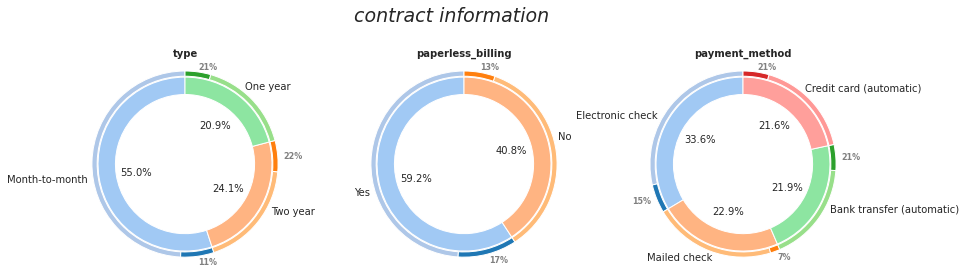

In [32]:
columns_list = ['type', 'paperless_billing', 'payment_method']

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plt.subplots_adjust(wspace=.25, hspace=0)
plt.suptitle('contract information', fontproperties={'style': 'italic', 'size': 19}, y=1.05)
for ax, col in zip(axes.flat, columns_list):
    chart_pie(data, col, ax, hue='is_former')

plt.show()

Круговые диаграммы следует воспринимать следующим образом: внутренний широкий контур показывает распределение категорий внутри признака, например, признак `type` имеет 3 уникальные категории `Month-to-month`, `One year`, `Two year`, с процентным распределением **55%**, **24.1%** и **20.9%** соответственно. Внешний же тонкий контур показывает, как внутри каждой категории распределены настоящие и ушедшие клиенты - первая полоса в каждом признаке, имеющая светлый оттенок, отображает долю текущих клиентов; полоса более темного оттенка показывает долю ушедших клиентов в каждой категории; а число в процентах серого цвета как раз описывает эту последнюю долю. К примеру, среди клиентов предпочитающих ежемесячный способ оплаты доля ушедших пользователей составляет **11%**.

1. Как уже было сказано выше, предусмотрено 3 разных типа оплат. Большинство пользователей, а именно **55%** предпочитают оплачивать услуги раз в месяц. Чуть меньше четверти клиентов вносят оплату сразу за 2 года. Примерно 1/5 пользователей оплачивают услуги раз в год. Абоненты, оплачивающие услуги раз в год или в два, склонны к уходу примерно вдвое чаще, чем те, кто оплачивает ежемесячно.
2. Около **60%** клиентов предпочитают электронное выставление счетов, **40%** еще пользуются бумажным вариантом. Второй тип клиентов более предан компании, и в меньшей доли случаев склонен к уходу.
3. Самый распространенный способ оплаты - электронный чек, им пользуются **33.6%** пользователей. Остальные способы оплаты занимают примерно равные доли - по **22% ±1%**. Стоит заметить, что среди тех, кто оплачивает услуги отправленным по почте чеком, самая низкая доля ушедших. Скорее всего это связано с тем, что оплачивающие бумажным чеком клиенты, в некоторой степени являются консервативными; а соответственно и на смену оператора связи им решиться сложнее. Наиболее высокая вероятность уйти у абонентов, оплачивающих кредитной картой и банковским переводом.

Перейдем к признакам, характеризующих самого клиента.

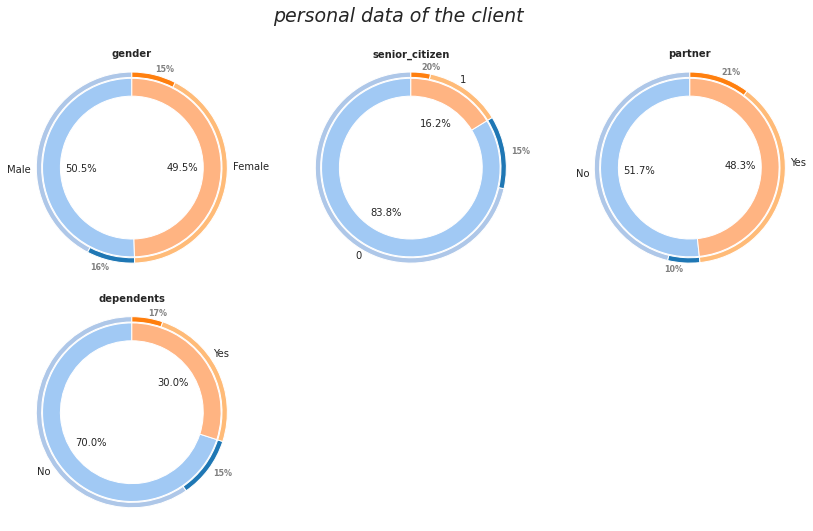

In [33]:
columns_list = ['gender', 'senior_citizen', 'partner', 'dependents']

fig, axes = plt.subplots(2, 3, figsize=(14, 9))
plt.subplots_adjust(wspace=.25, hspace=0)
plt.suptitle('personal data of the client', fontproperties={'style': 'italic', 'size': 19}, y=.94)
for ax, col in zip(axes.flat, columns_list):
    chart_pie(data, col, ax, hue='is_former')

# удаление пустых графиков
for i in [4, 5]:
    fig.delaxes(axes.flatten()[i])

plt.show()

1. Мужчин и женщин среди клиентов примерно поровну. Доля ушедших клиентов так же примерно одинаковая что для первых, что для вторых.
2. Пенсионеров среди пользователей примерно **16%**. Доля бывших клиентов среди пенсионеров выше.
3. Холостых несколько больше, чем женатых (замужних). Среди вторых доля ушедших клиентов вдвое выше.
4. **70%** клиентов имеют детей. Наличие или отсутствие детей практически не влияет на вероятность разрыва договора.

Рассмотрим последний блок категориальных признаков, отражающих информацию об интернет-услугах и услугах телефонии.

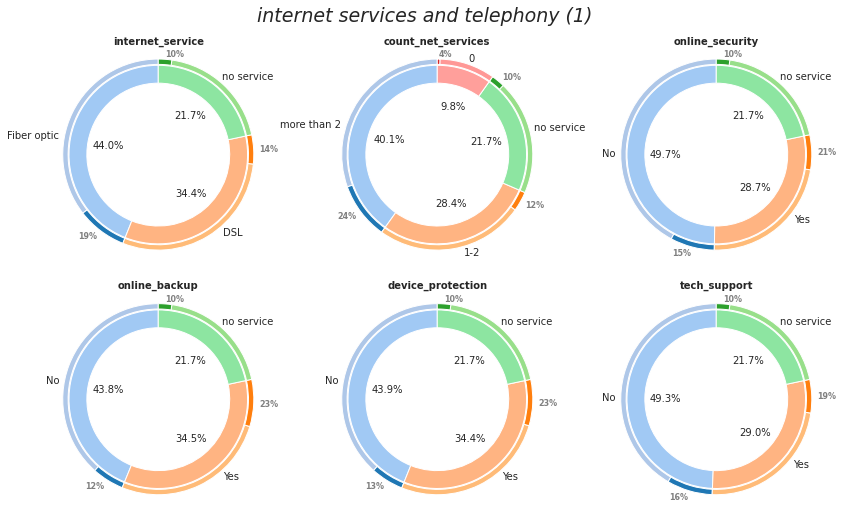

In [34]:
columns_list = ['internet_service', 'count_net_services', 'online_security', 'online_backup', 'device_protection', 'tech_support']

fig, axes = plt.subplots(2, 3, figsize=(14, 9))
plt.subplots_adjust(wspace=.25, hspace=0)
plt.suptitle('internet services and telephony (1)', fontproperties={'style': 'italic', 'size': 19}, y=.92)
for ax, col in zip(axes.flat, columns_list):
    chart_pie(data, col, ax, hue='is_former')

plt.show()

Среди всех клиентов интернет услугами пользуются **78.3%**, а услугами телефонии **90.3%**.
- <u>Использующие интернет-услуги:</u>
    1. Большинство абонентов подключены по оптоволокну. Меньшая, но все же значительная доля абонентов подключена по довольно устаревшей технологии DSL. Среди последних вероятность ухода от оператора связи несколько меньше.
    2. Примерно **40%** абонентов используют 3 и более интернет-услуги. На диаграмме видно, что данные клиенты покидают компанию практически в **четверти** случаев. Такая высокая вероятность может быть обусловлена высокими требованиями данных пользователей к дополнительным услугам, которые в конкурирующих компаниях либо более качественные, либо стоят дешевле.  
Среди тех, у кого подключено меньше трех услуг, или же не подключено вовсе, вероятность уйти всего **12%** и **4%**. У последних одна из самых низких вероятностей ухода, скорее всего это связано с тем, что данные клиенты либо не требовательны и им достаточно самого базового функционала, либо они недавно присоединились к компании.
    3. Примерно половина всех клиентов не пользуется услугой блокировки опасных сайтов.
    4. Услугами облачного хранилища пользуются **34.5%** всех абонентов, и среди них доля ушедших клиентов заметно выше, чем среди тех, кто данной услугой не пользуется. Возможно, стоит провести исследование и определить способы повышения качества облачного сервиса для минимизации оттока клиентов.
    5. С антивирусными услугами ситуация такая же, как с облачным хранилищем. Среди тех, кто пользуется антивирусом, предоставляемым компанией, доля ушедших клиентов больше, чем среди тех, кто антивирус не использует. Возможно, конкурирующие компании предлагают более качественный антивирусный сервис.
    6. Почти половина от всех клиентов не пользуется выделенной линией технической поддержки.

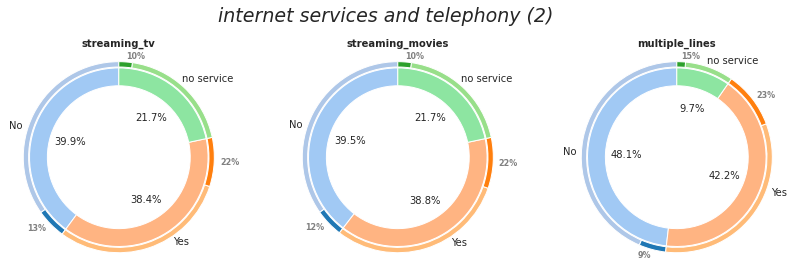

In [35]:
columns_list = ['streaming_tv', 'streaming_movies', 'multiple_lines']

fig, axes = plt.subplots(1, 3, figsize=(14, 5))
plt.subplots_adjust(wspace=.25, hspace=0)
plt.suptitle('internet services and telephony (2)', fontproperties={'style': 'italic', 'size': 19}, y=.92)
for ax, col in zip(axes.flat, columns_list):
    chart_pie(data, col, ax, hue='is_former')

plt.show()

   7. Тех кто использует и не использует стриминговое телевидение и каталог фильмов примерно поровну (если рассматривать только тех, у кого подключены интернет-услуги). И доля ушедших клиентов выше среди тех, кому важны данные сервисы.

Если обобщить вышесказанное, то клиенты, которые пользуются дополнительными интернет-услугами в большей доле случаев склонны к уходу, чем те, кто доп. услуги не использует.

- <u>Использующие услуги телефонии:</u>
    1. Несколько большая часть клиентов не пользуется возможностью ведения параллельных линий во время звонка. Но все же, значительная часть абонентов использует данную услугу, и среди последних доля ушедших значительно выше. Пользующиеся параллельными линиями - это более крупные клиенты, которые распределяют входящие звонки, поступающие на единый номер среди сотрудников. Соответственно, такие клиенты наиболее ценны для нас, так как приносят бОльший доход. Для наглядности сформируем сводную таблицу, в которой отобразим средние ежемесячные траты и средние траты за все время для тех, кто пользуется и не пользуется несколькими телефонными линиями.

In [36]:
data.pivot_table(index='multiple_lines', values={'monthly_charges': 'mean', 'total_charges': 'mean'})

,monthly_charges,total_charges
multiple_lines,,
No,54.195059,1312.582676
Yes,82.036974,3199.696749
no service,42.028592,1382.184663


Как видно из таблицы, каждый пользователь услуги `multiple_lines` в среднем за все время принес в **2.5** раза больше дохода в компанию, чем тот, кто не пользуется такой услугой. Так же средние ежемесячные расходы у пользователей услуги почти на **30** у.е. выше. 
Терять данных клиентов наиболее "больно" для компании с финансовой точки зрения. Поэтому необходимо провести исследование и установить причины, по которым клиенты использующие параллельные телефонные линии, в значительной доле случаев расторгают договоры.

Последние 3 признака, которые мы не рассмотрели - это признаки количественные. Построим для каждого из них гистограмму и боксплот. Группировку осуществим по целевому признаку.

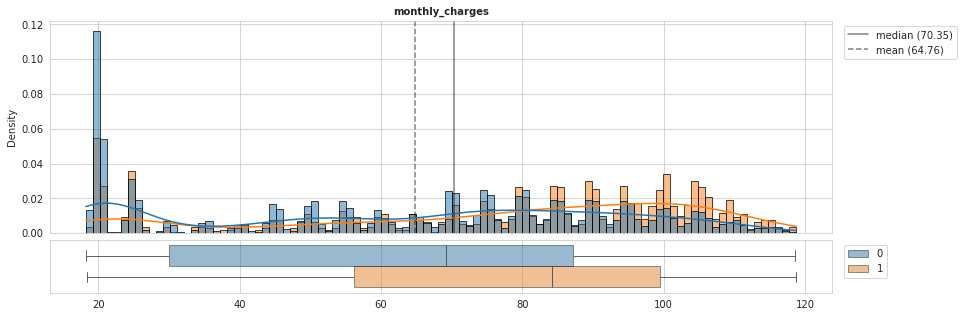

In [37]:
bins = int(np.ptp(data['monthly_charges']) + 1)
hist_box_chart(data, 'monthly_charges', hue='is_former', bins=bins)

Помесячные расходы сгруппировались на гистограмме интересным образом - каждый пик кратен 5. Скорее всего это связано с тем, что цена многие услуги так же кратна 5.
Самый частый ежемесячный платеж равен **20** у.е. - вероятнее всего это цена базового тарифа. Медиана по всему датасету составляет около **70**, среднее значение чуть ниже медианы - примерно **65**.
Boxplot говорит о том, что ушедшие клиенты, в основном, вносили более высокие ежемесячные платежи. Они вероятнее всего ушли к конкурентам по причине неудовлетворенности качеством или ценой некоторых услуг, например, параллельными телефонными линиями.

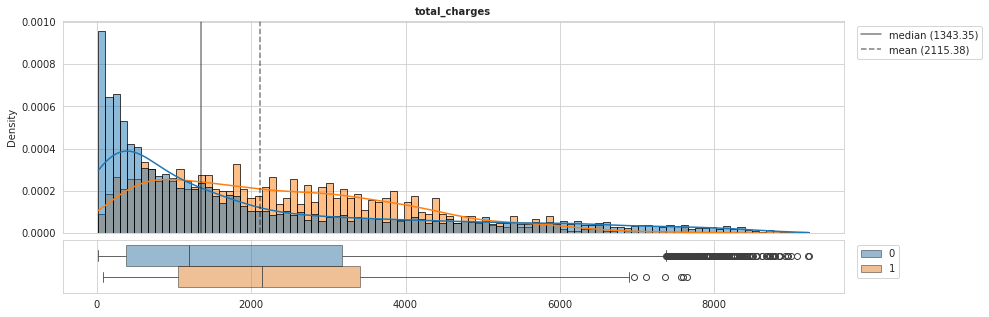

In [38]:
hist_box_chart(data, 'total_charges', hue='is_former', bins=100)

Распределение общих трат имеет длинный хвост справа, на котором, вероятнее всего в большинстве случаев, расположены более или менее крупные коммерческие клиенты. Основная масса клиентов принесла в компанию менее 2000 у.е. У ушедших клиентов медианные траты были выше, чем у действующих. Что говорит о том, что мы теряем платежеспособную аудиторию.

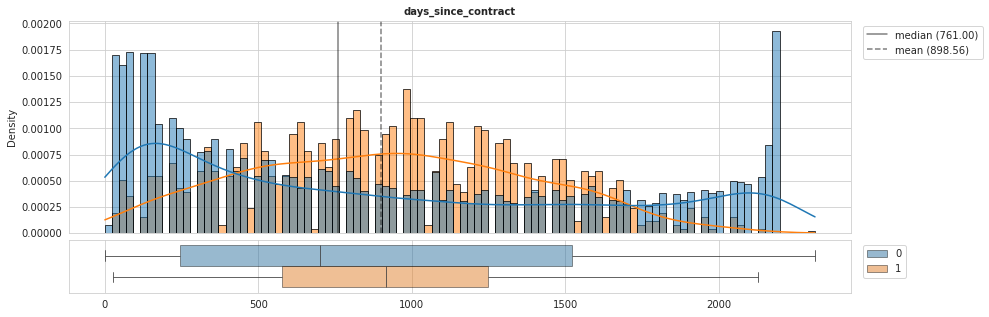

In [39]:
hist_box_chart(data, 'days_since_contract', hue='is_former', bins=100)

Признак, показывающий количество дней с момента заключения контракта на гистограмме распределился некоторыми группами, это связано с тем, что в исходных данных информация о дате заключения договора представлена с точностью до месяца. На графике видно, что пик отказа от договора приходится примерно на 1000 день со дня подписания (оранжевая часть на гистограмме). Медианная длительность контракта выше у тех, кто расторг договор - это может свидетельствовать о снижении лояльности старой аудитории, которая по какой-то из причин решается расторгнуть договор.

Проанализируем среднестатистического действующего и ушедшего абонентов. Для этого сформируем таблицу в которой индексами будут выступать названия категориальных признаков, а в двух столбцах будут наиболее частые значения (мода) для двух разных типов клиентов.

In [40]:
data_group_mode = data.pivot_table(
    columns='is_former',
    values=data.select_dtypes(include='object').columns.tolist(),
    aggfunc=lambda x: x.mode().iloc[0])


def highlight_differences(row):
    if row[0] == row[1]:
        return ['font-style: italic; color:gray'] * 2
    else:
        return ['font-weight: bold'] * 2

data_group_mode.style.apply(highlight_differences, axis=1)

is_former,0,1
count_net_services,more than 2,more than 2
dependents,No,No
device_protection,No,Yes
gender,Male,Male
internet_service,Fiber optic,Fiber optic
multiple_lines,No,Yes
online_backup,No,Yes
online_security,No,No
paperless_billing,Yes,Yes
partner,No,Yes


Видим, что для 10 из 16 признаков мода совпадает для ушедшего и нынешнего клиентов. Если коротко обобщить, то среднестатистический ушедший клиент, в отличие от действующего, использует антивирус, параллельные звонки, облачный бэкап, является женатым (замужней) и использует стриминговые сервисы для просмотра фильмов и телевидения.

Точно такую же табличку сформируем и для 3-х количественных признаков. В качестве значений на пересечении строк и столбцов будет среднее.

In [41]:
data_group_mean = data.pivot_table(
    columns='is_former',
    values=['monthly_charges', 'total_charges', 'days_since_contract'],
    aggfunc='mean'
)


data_group_mean['difference'] = data_group_mean[0] - data_group_mean[1]

(
    data_group_mean
    .style
    .format(precision=2)
    .map(lambda x: 'color: #f95d4c' if x < 0 else 'color:#3caa3c', subset='difference')
)

is_former,0,1,difference
days_since_contract,893.68,924.86,-31.18
monthly_charges,62.76,75.55,-12.78
total_charges,2067.94,2371.38,-303.43


Ушедшие клиенты в среднем имели ежемесячные платежи примерно на **13** у.е. выше; а средний общий доход с каждого ушедшего клиента больше на **303** у.е., чем у текущего. Так же средний ушедший абонент являлся частью компании примерно на **месяц** дольше, чем среднестатистический текущий. Все это говорит о том, что компания теряет наиболее доходную часть аудитории, причем в лице старых клиентов.

### Корреляционный анализ

Рассмотрим корреляцию признаков. Опираться будем на коэффициент фик.

In [42]:
num_col = ['monthly_charges', 'total_charges', 'days_since_contract']

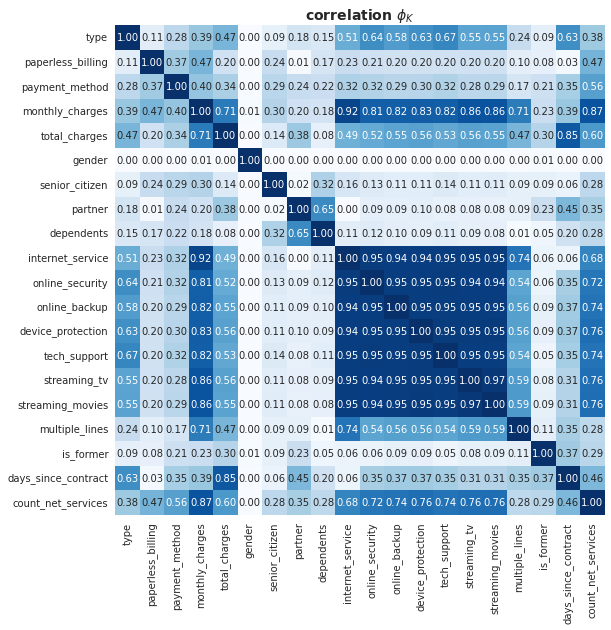

the highest correlation coefficients:


,feature_1,feature_2,corr,cheddock_scale
0,streaming_tv,streaming_movies,0.965306,multicollinearity
1,streaming_movies,device_protection,0.953717,multicollinearity
2,device_protection,streaming_tv,0.952863,multicollinearity
3,tech_support,online_security,0.952651,multicollinearity
4,device_protection,tech_support,0.950247,multicollinearity
5,internet_service,online_security,0.949498,multicollinearity
6,internet_service,tech_support,0.948914,multicollinearity
7,online_backup,tech_support,0.947756,multicollinearity
8,device_protection,online_backup,0.947487,multicollinearity
9,online_security,online_backup,0.947224,multicollinearity


In [43]:
phik_overview = data.phik_matrix(interval_cols=num_col)
corr_matrix(phik_overview)

print(f'{Ansi.bold}the highest correlation coefficients:{Ansi.end}')
corr_sort(phik_overview).head(10)

Так как нет общепринятой четкой границы для коэффициента корреляции, после пересечения которой связь двух величин можно считать мультиколлинеарной, то условно примем за такую границу значение 0.9.  
Видно, что признаки характеризующие интернет-услуги, присутствовавшие в изначальном датасете, сильно коррелируют между собой; к тому же они слабо коррелируют с таргетом - следовательно, мы можем от них избавиться. Сформированный нами на их основе признак `count_net_services` не имеет мультиколлинеарности с другими фичами, и с таргетом коррелирует получше - его мы оставим.

In [44]:
col_internet = internet.columns.tolist()
data = data.drop(col_internet, axis=1)

Еще раз отобразим матрицу корреляции, но уже без удаленных признаков.

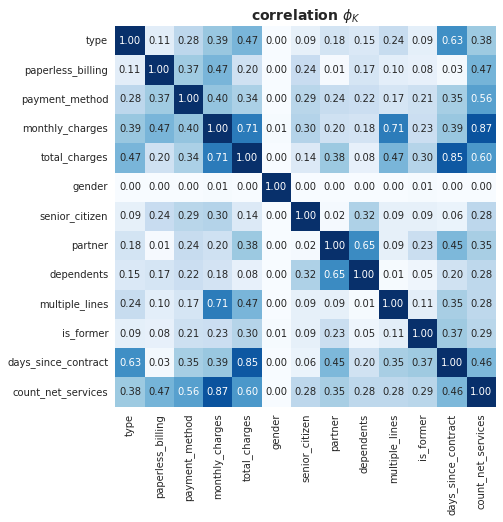

the highest correlation coefficients:


,feature_1,feature_2,corr,cheddock_scale
0,monthly_charges,count_net_services,0.866817,high
1,total_charges,days_since_contract,0.847414,high
2,total_charges,monthly_charges,0.711161,high
3,monthly_charges,multiple_lines,0.710101,high
4,dependents,partner,0.652122,perceptible
5,type,days_since_contract,0.634155,perceptible
6,count_net_services,total_charges,0.596710,perceptible
7,count_net_services,payment_method,0.558854,perceptible
8,count_net_services,paperless_billing,0.474063,moderate
9,type,total_charges,0.468471,moderate



correlation for the target:


,corr,cheddock_scale
days_since_contract,0.374569,moderate
total_charges,0.304287,moderate
count_net_services,0.291776,weak
partner,0.226688,weak
monthly_charges,0.225925,weak
payment_method,0.214832,weak
multiple_lines,0.105101,weak
type,0.094015,no correlation
senior_citizen,0.086159,no correlation
paperless_billing,0.083398,no correlation


In [45]:
phik_overview = data.phik_matrix(interval_cols=num_col)
corr_matrix(phik_overview, size=7)

print(f'{Ansi.bold}the highest correlation coefficients:{Ansi.end}')
display(corr_sort(phik_overview).head(10))

print(f'\n{Ansi.bold}correlation for the target:{Ansi.end}')
target_corr(phik_overview, 'is_former')

От мультиколлинеарности мы избавились, а так же сократили признаковое описание без особой потери в информативности. Наиболее сильно коррелируют с целевым признаком следующие - `days_since_contract`, `total_charges` и `count_net_services`.

## Подготовка данных

Разделим данные на train и test в соотношении 3:1. При разбиении воспользуемся стратификацией по таргету, так как в данных имеется дисбаланс классов.

In [46]:
target = 'is_former'
X = data.drop(target, axis=1)
y = data[target]

cat_col = X.select_dtypes(include='object').columns.tolist()
num_col = X.select_dtypes(exclude='object').columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    random_state=SEED,
    test_size=.25
)

data_shape = {
    'train': [X_train.shape, y_train.shape, f'{y_train.value_counts(normalize=True)[1]:.2%}'],
    'test': [X_test.shape, y_test.shape, f'{y_test.value_counts(normalize=True)[1]:.2%}']
}

pd.DataFrame(data_shape, index=['X', 'y', 'target=1 (%)']).T

,X,y,target=1 (%)
train,"(5282, 12)","(5282,)",15.64%
test,"(1761, 12)","(1761,)",15.62%


## Обучение моделей

In [47]:
# Объявим датафрейм, в который будем заносить результаты протестированных моделей
rating_model = pd.DataFrame()

In [48]:
def rating_model_display(estimator, roc_auc, accuracy, precision, recall, threshold, title=None):
    """Занесение показаний в таблицу и вывод одной строки"""
    
    # получаем название модели
    if title is None:
        m_name = f'{model_name(estimator)}'
    else:
        m_name = f'{model_name(estimator)} ({title})'

    # заносим результаты в таблицу
    rating_model.loc[m_name, 'ROC AUC'] = roc_auc
    rating_model.loc[m_name, 'accuracy'] = accuracy
    rating_model.loc[m_name, 'precision'] = precision
    rating_model.loc[m_name, 'recall'] = recall
    rating_model.loc[m_name, 'threshold'] = threshold

    # выводим сформированную табличку с метриками
    result = (
        rating_model
        .loc[[m_name]]
        .style
        # выделение жирным шрифтом главной метрики с округлением до 4 знаков
        .format('<b>{:.4f}</b>', subset=['ROC AUC']) 
        # вторичные метрики округляем до 2 знаков
        .format(precision=2, subset=['accuracy', 'precision', 'recall'])
        .format(precision=4, subset=['threshold'])
    )
    
    return result

In [49]:
def model_name(estimator):
    """
    Функция принимает модель. Возвращает название модели в виде строки.
    """
    
    if isinstance(estimator, Pipeline):
        return estimator['model'].__class__.__name__
    else:
        return estimator.__class__.__name__

In [50]:
def feature_importances_chart(estimator, count=15):
    """
    Функция для отрисовки графика с важностью признаков.
    """
    
    if model_name(estimator) == 'CatBoostClassifier':
        coefs = estimator.get_feature_importance(prettified=True)
        coefs.columns = ['feature_id', 'importances']

    else:
        feature_id = estimator[0].get_feature_names_out()
        feature_id = [re.sub('.*__', '', name) for name in feature_id]
        importances = estimator['model'].coef_[0]
        coefs = pd.DataFrame({'feature_id': feature_id, 'importances': importances})
        coefs['abs'] = coefs['importances'].apply(np.abs)
        coefs = coefs.sort_values(by='abs', ascending=False).drop('abs', axis=1).query('importances != 0').reset_index(drop=True)

    coefs_head = coefs.head(count)
    
    _, ax = plt.subplots(figsize=(14, 5))
    sns.barplot(data=coefs_head, x='importances', y='feature_id', hue='feature_id', palette=sns.dark_palette("#69d", coefs_head.shape[0], reverse=True), ax=ax)
    ax.set_title(f'feature importances (total: {coefs.shape[0]})', fontweight='bold')
    ax.set_xlabel('importances')
    ax.set_ylabel('')
    plt.show()

In [51]:
def optuna_search(
    estimator_func, 
    params_func, 
    X, 
    y,
    n_trials=30, 
):
    """
    Подбор гиперпараметров с применением байесовской оптимизации.
    Для расчета метрики используется кросс-валидация.
    Функция возвращает лучшую необученную модель.
    """
    
    def objective(trial):
        params = params_func(trial)
        estimator = estimator_func(params)
        
        metric = cross_val_score(
            estimator, 
            X, 
            y, 
            n_jobs=-1,
            cv=4,
            scoring='roc_auc'
        ).mean()

        return metric

    
    study = optuna.create_study(
        direction='maximize', 
        sampler=optuna.samplers.TPESampler(seed=SEED), 
        pruner=optuna.pruners.HyperbandPruner()
    )
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    best_params = study.best_params
    best_estimator = estimator_func(best_params)

    # Выводим список лучших гиперпараметров
    print(f'{model_name(best_estimator)} best parameters:')
    print(best_params)

    return best_estimator

In [52]:
def model_cross_val(estimator, X, y):
    """
    Оценка качества модели на кросс-валидации и сохранение результатов в таблицу.
    Функция возвращает модель, обученную на всех данных.
    """

    cv_predict_proba = cross_val_predict(
        estimator, 
        X, 
        y, 
        n_jobs=-1,
        cv=4,
        method='predict_proba' 
    )[:, 1]

    # начальное значение порога классификации
    threshold = .5
    # минимальный требуемый recall
    required_recall = .85
    cv_predict = (cv_predict_proba >= threshold).astype(int)
    
    # если значение recall ниже заданного порога на стандартном threshold в 0.5,
    # то находим такой threshold, который позволяет получить требуемый recall
    if recall_score(y, cv_predict) < required_recall:
        _, recalls, thresholds = precision_recall_curve(y, cv_predict_proba)
        idx = np.argmin(recalls >= required_recall)
        threshold = thresholds[idx]
        cv_predict = (cv_predict_proba >= threshold).astype(int)

    # рассчитываем метрики
    roc_auc = roc_auc_score(y, cv_predict_proba)
    accuracy = accuracy_score(y, cv_predict)
    precision = precision_score(y, cv_predict)
    recall = recall_score(y, cv_predict)
    
    # выводим табличку с метриками
    display(
        rating_model_display(estimator, roc_auc, accuracy, precision, recall, threshold, title='cv')
    )
    
    # обучаем модель на всех данных, что бы подать на выход функции,
    # а так же получить получить feature_importances
    trainded_model = estimator.fit(X, y)

    # модель catboost позволяет задать необходимый threshold,
    # метод predict будет сразу его учитывать
    if model_name(estimator) == 'CatBoostClassifier':
        estimator.set_probability_threshold(threshold)

    # график с важностью признаков
    feature_importances_chart(trainded_model)

    return trainded_model

### LogisticRegression

В качестве первой модели рассмотрим логистическую регрессию. Перед подачей датасета в модель необходимо закодировать категориальные признаки, для этого воспользуемся OneHotEncoder; а числовые признаки приведем к единому масштабу. Попробуем подобрать оптимальные гиперпараметры с помощью байесовской оптимизации. Подбирать будем алгоритм оптимизации и силу регуляризации.

In [53]:
data_preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', sparse_output=False), cat_col),
    (StandardScaler(), num_col),
    remainder='passthrough', 
    force_int_remainder_cols=False
)

  0%|          | 0/50 [00:00<?, ?it/s]

LogisticRegression best parameters:
{'solver': 'saga', 'C': 81.60848604760861}


,ROC AUC,accuracy,precision,recall,threshold
LogisticRegression (cv),0.7584,0.50,0.22,0.85,0.0855


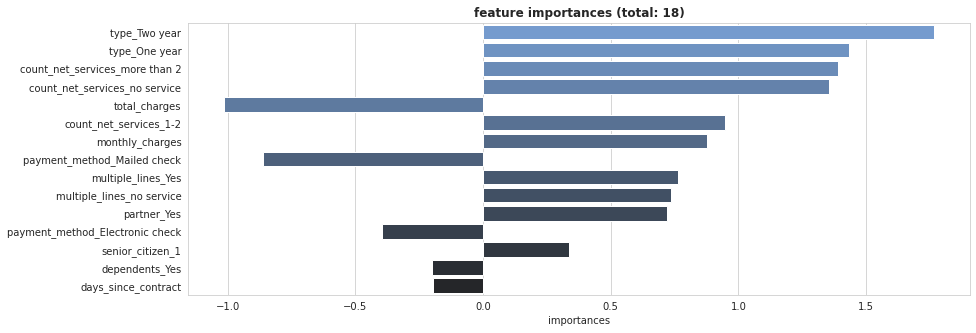

In [54]:
def optuna_model_lr(params):  
    estimator = Pipeline([
        ('preprocessor', data_preprocessor),
        ('model', LogisticRegression(**params, random_state=SEED))
    ])
    return estimator


def optuna_params_lr(trial):
    params = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'newton-cg', 'sag', 'saga']),
        'C': trial.suggest_float('C', 0, 100)
    }
    return params


model_lr = optuna_search(optuna_model_lr, optuna_params_lr, X_train, y_train, n_trials=50)
model_lr = model_cross_val(model_lr, X_train, y_train)

**Вывод:** с нашим датасетом линейная модель справилась довольно плохо. Метрика $ROC-AUC = 0.76$ не дотягивает до требуемого уровня.

Наша задача подразумевает, что нам необходимо минимизировать ошибки второго рода, т.е. `False Negative` или `FN`, так как лучше, к примеру, предложить скидку клиенту, который не собирался покидать компанию, чем не обратить внимание на потенциально готового уйти; поэтому, нам так же важно контролировать метрику $recall$. Но если подобрать такой порог классификации, при котором `FN` будут максимально низкими, то в таком случае очень сильно возрастут ошибки первого рода, т.е. `FP`, и мы почти всех клиентов будем принимать за готовых уйти, что так же не самый лучший вариант. Поэтому необходимо соблюсти некий баланс, при котором общая точность модели и метрика $recall$ будут достаточно высоки. Подобрать порог классификации можно разными способами, но так как в условиях не предъявлено конкретных требований к $accuracy$ и $recall$, то примем за минимально приемлемую точность $recall = 0.85$. Данное значение позволяет на более-менее точных моделях так же получить и общую точность на достаточно приемлемом уровне, не слишком сильно поднимая количество ошибок `FP`.

Низкое значение $precision$ говорит о том, что модель очень часто ошибочно присваивает **1** класс. Общая доля правильных ответов при подобранном пороге классификации составляет **50%**. Общую точность и $precision$ можно поднять, изменив `threshold`, но в таком случае модель будет хуже предсказывать наиболее важный для нас класс.  
На графике важности признаков видим, что такие фичи, как `тип оплаты раз в 2 года`, `количество интернет-сервисов более 2-х` или `отсутствие интернет услуг` склоняют модель к присваиванию объекту класса **1**. Тогда как `высокие общие траты`, `оплата бумажным` и `электронным чеком` будут склонять модель в сторону **0** класса.

### CatBoost

В качестве второй и более сложной модели рассмотрим градиентный бустинг. CatBoost сам умеет обрабатывать категориальные признаки, необходимо просто указать названия колонок с такими фичами. Модели, основанные на деревьях решений не чувствительны к масштабу признаков, поэтому числовые фичи можно не стандартизировать.  
Попробуем подобрать оптимальные значения для 4-х гиперпараметров. Код с поиском параметров я закомментирую, так как обучение градиентного бустинга на CPU может занимать продолжительное время. Ниже будет модель с уже подобранными параметрами. Но при желании код можно раскомментировать.

In [55]:
# def optuna_model_catboost(params):
#     estimator = CatBoostClassifier(
#         **params,
#         auto_class_weights='Balanced',
#         cat_features=cat_col,
#         random_seed=SEED,
#         verbose=0)
    
#     return estimator


# def optuna_params_catboost(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 1000, 8000),
#         'learning_rate': trial.suggest_float('learning_rate', .005, .05),
#         'depth': trial.suggest_int('depth', 3, 6),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 20)
#     }
    
#     return params


# model_catboost = optuna_search(optuna_model_catboost, optuna_params_catboost, X_train, y_train, n_trials=100)

,ROC AUC,accuracy,precision,recall,threshold
CatBoostClassifier (cv),0.9237,0.84,0.49,0.85,0.0922


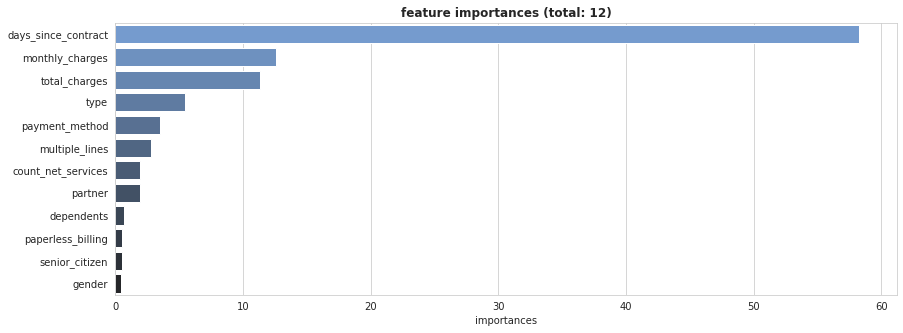

In [56]:
model_catboost = CatBoostClassifier(
    **{'iterations': 7791, 'learning_rate': 0.03705409972234926, 'depth': 3, 'l2_leaf_reg': 2.2030955226401003},
    cat_features=cat_col,
    random_seed=SEED,
    verbose=0)

model_catboost = model_cross_val(model_catboost, X_train, y_train)

**Вывод:** результат гораздо лучше, чем на логистической регрессии. Метрика $ROC-AUC  = 0.92$, что удовлетворяет поставленным требованиям. Модель при заданном минимальном $recall = 0.85$  выдает общую точность, равную **84%**. Метрика $precision$ не блещет высокими значениями - чуть больше половины пользователей, которым модель присваивает класс **1**, на самом деле не собираются покидать компанию. Но более низкие $precision$ и $accuracy$ - это плата за то, что модель выявляет больше пользователей, действительно готовых уйти.
 

Наиболее сильный вклад в принятие решения моделью вносят такие признаки, как `days_since_contract`, `monthly_charges` и `total_charges`.

## Анализ лучшей модели на тестовых данных

Сравнительная таблица для двух протестированных моделей

In [57]:
(
    rating_model
    .style
    .format('<b>{:.4f}</b>', subset=['ROC AUC']) 
    .format(precision=2, subset=['accuracy', 'precision', 'recall'])
    .format(precision=4, subset=['threshold'])
)

,ROC AUC,accuracy,precision,recall,threshold
LogisticRegression (cv),0.7584,0.50,0.22,0.85,0.0855
CatBoostClassifier (cv),0.9237,0.84,0.49,0.85,0.0922


Как уже было сказано выше, градиентный бустинг показал себя намного лучше линейной модели.  
Настало время протестировать полученную модель на тестовом датасете.

In [58]:
predict = model_catboost.predict(X_test)
predict_proba = model_catboost.predict_proba(X_test)[:, 1]
threshold = model_catboost.get_probability_threshold()

roc_auc = roc_auc_score(y_test, predict_proba)
accuracy = accuracy_score(y_test, predict)
precision = precision_score(y_test, predict)
recall = recall_score(y_test, predict)

rating_model_display(model_catboost, roc_auc, accuracy, precision, recall, threshold, title='test')

,ROC AUC,accuracy,precision,recall,threshold
CatBoostClassifier (test),0.9247,0.82,0.46,0.87,0.0922


На тесте целевая метрика практически не отличается от той, что мы получили на тренировочных данных, и равняется **0.9247**, что перекрывает минимально установленную планку в 0.85. $accuracy$ так же осталась примерно на уровне тестовой выборки.

Проверим полученную нами модель на адекватность, для этого сравним ее результаты с другой моделью, которая всегда присваивает наблюдениям наиболее распространенную метку класса.

In [59]:
dummy_model = DummyClassifier(random_state=SEED)
dummy_model.fit(X_train, y_train)

dummy_predict_proba = dummy_model.predict_proba(X_test)[:, 1]
dummy_predict = dummy_model.predict(X_test)

roc_auc = roc_auc_score(y_test, dummy_predict_proba)
accuracy = accuracy_score(y_test, dummy_predict)
precision = precision_score(y_test, dummy_predict, zero_division=0)
recall = recall_score(y_test, dummy_predict)

rating_model_display(dummy_model, roc_auc, accuracy, precision, recall, .5, title='test')

,ROC AUC,accuracy,precision,recall,threshold
DummyClassifier (test),0.5000,0.84,0.00,0.00,0.5000


Целевая метрика в таком случае равняется **0.5**. Общая точность такой модели хоть и находится на уровне **84%**, но она ни одного объекта не отнесла к **первому**, более малочисленному классу, соответственно метрики $precision$ и $recall$ равны 0.  
Сравнивая результаты обученной нами модели с моделью константной излишне говорить, что первая справляется со своей задачей куда лучше.

Взглянем на матрицу ошибок для нашей модели.

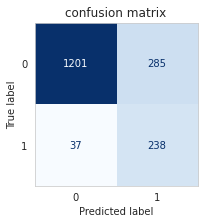

In [60]:
_, ax = plt.subplots(figsize=(3, 3))
ConfusionMatrixDisplay.from_predictions(y_test, predict, ax=ax, cmap='Blues', colorbar=False)
plt.title('confusion matrix')
plt.grid(False)
plt.show()

В **238** случаях из **275** (а именно в **87%**) модель верно предсказала уход клиента. Но данная модель ошибочно посчитала **285** клиентов, как готовых расторгнуть договор. Как уже писалось выше, для нас наиболее критичны ошибки второго рода, поэтому возросшее значение `FP` - это некоторая компенсация за более точное распознавание действительно готовых уйти. Лучше перестраховаться и предложить некоторый бонус не собиравшемуся уходить абоненту, чем потерять клиента вообще.

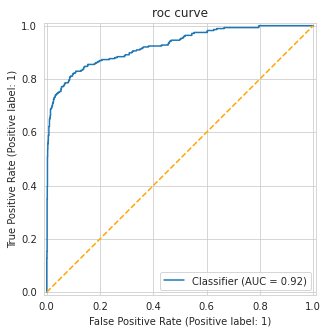

In [61]:
_, ax = plt.subplots(figsize=(5, 5))
RocCurveDisplay.from_predictions(y_test, predict_proba, ax=ax)
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.title('roc curve')
plt.show()

Наша целевая метрика $ROC-AUC$ это количественная интерпретация площади под ROC кривой, чем она больше - тем выше точность модели без привязки к конкретному порогу классификации. В нашем случае эта площадь получилась равной **0.91**, что является довольно неплохим показателем.

С помощью библиотеки **SHAP** рассмотрим, какие признаки вносят наибольший вклад в принятие решений моделью. Первый график `global feature importance` отражает общий вклад каждого признака в результат. На втором графике `beeswarm plot` можно детальнее пронаблюдать, как каждое конкретное наблюдение в каждом признаке склоняет модель в ту или иную сторону, в зависимости от величины значения. (Серым цветом на втором графики изображены категориальные признаки)

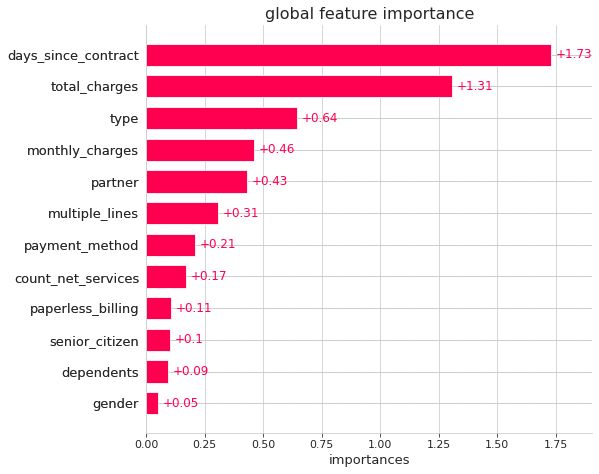

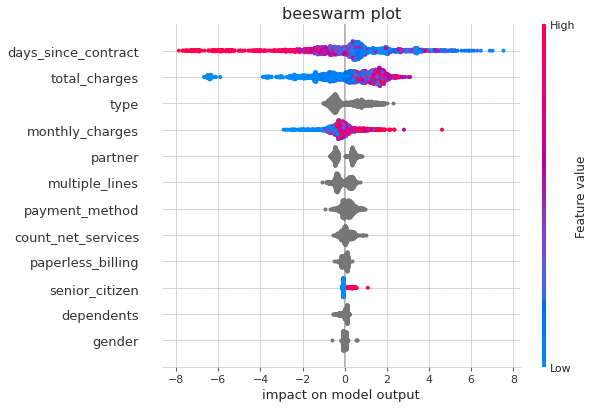

In [62]:
explainer = shap.TreeExplainer(model_catboost)
shap_values = explainer(X_test)


shap.plots.bar(shap_values, max_display=12, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title('global feature importance', fontsize=16)
ax.set_xlabel('importances')
plt.show()


shap.plots.beeswarm(shap_values, max_display=12, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title('beeswarm plot', fontsize=16)
ax.set_xlabel('impact on model output')
plt.show()

Сильнее всего на принятие решения моделью влияет признак `days_since_contract` - количество дней с момента подписания контракта. Высокие значения данного признака (в большинстве случаев) склоняю модель присвоить класс **0**, т.е. давние клиенты компании склонны к продолжению сотрудничества. Признак `total_charges` при высоких значениях (во многих случаях) склоняет модель присвоить класс **1**, т.е. клиенты, принесшие компании достаточно большие суммы, склонны со временем расторгать договор. Признак `monthly_charges` имеет такую же, но уже более ярко выраженную тенденцию к уходу наиболее доходной аудитории. Из категориальных признаков наиболее сильным влиянием обладают `type` - тип оплаты, `partner` - наличие партнера, и `multiple_lines` - наличие параллельных линий во время звонка.

## Выводы

**Поставленная задача:**  построить модель для прогноза оттока клиентов.

**Требования:** метрика $ROC-AUC >= 0.85$.

**В рамках проекта выполнено следующее:**
1. Данные загружены, изучены и предобработаны. 4 отдельных датафрейма объединены в один. Устранены пропуски, сформированы новые признаки на основе имеющихся.
2. Произведен исследовательский анализ данных, в ходе которого проанализированы все признаки. Так же установлено, какие переменные в наибольшей степени могут указывать на вероятный уход клиента. Так же предложены некоторые возможные варианты решения проблем.
3. Обучено две модели ML: первая - линейная, вторая - бустинг. Использованы автоматизированные методы для поиска оптимальных гиперпараметров, позволяющих получить наиболее высокое значение целевой метрики. Так же выполнен подбор порога классификации для минимизации ошибок FN.
4. Выбрана лучшая модель и протестирована на тестовой выборке. Получено значение целевой метрики $ROC-AUC = 0.9247 	$, что удовлетворяет требованиям заказчика. Так же рассмотрена матрица ошибок и дополнительно проанализированы графики важности признаков для тестовой выборки.


Разработанная нами модель ML способна в **84%** случаев верно определить потенциально готового расторгнуть договор клиента - с такими абонентами можно дополнительно работать, предлагая более выгодные условия и приятные бонусы. Общая точность модели составляет **81%**, т.е. в некоторой доле случаев модель может идентифицировать клиента, как готового уйти, хотя это не так. Но лучше дополнительно проработать несколько таких клиентов, чем потерять вообще.


Если коротко резюмировать, то наиболее склонны к разрыву договора клиенты, которые активно пользуются дополнительными интернет-услугами или услугами параллельных телефонных линий. Для минимизации оттока клиентов можно предпринять следующее:
1. Прорабатывать клиентов, которых модель отнесет к категории готовых разорвать договор. Предлагать скидки на сервис и доп услуги.
2. Рассмотреть вариант введения системы скидок, зависящей от текущей длительности договора, если такой системы еще нет. Так как было установлено, что значительная часть старых клиентов, которая могла бы и дальше приносить прибыль, разрывает договора.
3. Провести исследование и проанализировать цены на аналогичные услуги у конкурентов. У клиентов, пользующихся доп услугами, была установлена повышенная вероятность разрыва договора. Возможно конкурирующие компании предлагают более дешевый сервис.
4. Провести исследование и проанализировать качество предоставляемых услуг, относительно качества у конкурентов. Возможно клиенты, пользующиеся доп. услугами, решаются на смену оператора связи не из-за стоимости, а из-за каких-либо проблем с качеством этих предоставляемых услуг.